In [173]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization (Static)
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization (Interactive)
import plotly.express as px

# Machine Learning & Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Import Data 

In [174]:
# 1) Cleaned dataset with variables 
final_dataset=pd.read_csv("comprehensive_dataset_2.csv")
"""clmns_cluster=['Economic Complexity', 
       'Gross domestic product (GDP), Per capita, purchasing power parity (PPP) international dollar, ICP benchmarks 2017-2021',
       'Mineral rents (% of GDP)', 'Natural gas rents (% of GDP)',
       'Oil rents (% of GDP)', 
       'Revenue, General government, Percent of GDP','Rents']"""

# 2) Original clusters from Leo       
clusters_list = pd.read_csv('clusters_list.csv').set_index('Country Code')

# 3) Manufacturing, value added (% of GDP) https://data.worldbank.org/indicator/NV.IND.MANF.ZS
manufacturing = pd.read_csv('../../data/API_NV.IND.MANF.ZS_DS2_en_csv_v2_130159.csv', skiprows=4)

# 4) Medium and high-tech manufacturing value added: https://data.worldbank.org/indicator/NV.MNF.TECH.ZS.UN
high_tech = pd.read_csv('../../data/API_NV.MNF.TECH.ZS.UN_DS2_en_csv_v2_6516.csv', skiprows=4)

# 5) Industry (including construction), value added (% of GDP)
industry = pd.read_csv('../../data/API_NV.IND.TOTL.ZS_DS2_en_csv_v2_6498.csv', skiprows=4)

# 6) Agriculture, forestry, and fishing, value added (% of GDP) https://data.worldbank.org/indicator/NV.AGR.TOTL.ZS
agriculture = pd.read_csv('../../data/API_NV.AGR.TOTL.ZS_DS2_en_csv_v2_128624.csv', skiprows=4)

# 7) Services, value added (% of GDP) https://data.worldbank.org/indicator/NV.SRV.TOTL.ZS 
services = pd.read_csv('../../data/API_NV.SRV.TOTL.ZS_DS2_en_csv_v2_129290.csv', skiprows=4)

# Cluster variations across time 

### Pre-processing 

##### World bank data

In [175]:
# 2) World Bank indicators
wb = pd.concat([agriculture, services, industry, manufacturing], ignore_index=True)

wb = wb.drop(columns=['Indicator Code'])

wb = wb.rename(columns={
    'Indicator Name': 'Series Name',
    'year': 'Year',
    'value': 'Value'
})

# Years to 1 variable
wb_long = pd.melt(
    wb,
    id_vars= ['Country Name', 'Country Code','Series Name'],  # columns to keep fixed
    value_vars=[str(year) for year in range(1960, 2025)],  # columns to melt
    var_name='Year',                       # name of the new column for years
    value_name='Value'       # name of the new column for values
)

#### Append final dataset and World Bank variables

In [176]:
final_dataset = pd.concat([final_dataset, wb_long], ignore_index=True)
final_dataset

,Country Code,Series Name,Year,Country Name,Value
0,AFG,Economic Complexity,1991.0,Afghanistan,-0.451000
1,AFG,Economic Complexity,1992.0,Afghanistan,-0.451000
2,AFG,Economic Complexity,1993.0,Afghanistan,-0.451000
3,AFG,Economic Complexity,1994.0,Afghanistan,-0.451000
4,AFG,Economic Complexity,1995.0,Afghanistan,-0.451000
...,...,...,...,...,...
117775,XKX,"Manufacturing, value added (% of GDP)",2024,Kosovo,13.073106
117776,YEM,"Manufacturing, value added (% of GDP)",2024,"Yemen, Rep.",NaN
117777,ZAF,"Manufacturing, value added (% of GDP)",2024,South Africa,12.797686
117778,ZMB,"Manufacturing, value added (% of GDP)",2024,Zambia,9.284074


In [186]:
# I will take 5-year averages (from 1991 to 1995, and 2020 to 2024)

# Only use years from 2015 to 2021
final_dataset['Year'] = final_dataset['Year'].astype(int)
df_start_end = final_dataset[final_dataset['Year'].isin([1991, 1992, 1993, 1994, 1995, 2020, 2021, 2022, 2023, 2024])].copy()
df_start_end['Year'] = df_start_end['Year'].astype(int) 

#Pivot the data to wide format
data_pivot_var = df_start_end.pivot_table(
    index=['Country Code', 'Series Name'], 
    columns='Year', 
    values='Value'
)

# Take 5-year averages
years_91_95 = [1991, 1992, 1993, 1994, 1995]
years_20_24 = [2020, 2021, 2022, 2023, 2024]

data_pivot_var['avg_1991_1995'] = data_pivot_var[years_91_95].mean(axis=1)
data_pivot_var['avg_2020_2024'] = data_pivot_var[years_20_24].mean(axis=1)

# Calculate absolute change between 5-year averages
df_change = (data_pivot_var['avg_2020_2024'] - data_pivot_var['avg_1991_1995']).reset_index()
df_change.columns = ['Country Code', 'Series Name', 'Net_Change'] 

# To wide format
data_wide_change = df_change.pivot(
    index='Country Code', 
    columns='Series Name', 
    values='Net_Change'
)

# Dropping NAs
data_wide_imputed_var = data_wide_change.dropna()

data_wide_imputed_var = data_wide_imputed_var.rename(columns={
    'Manufacturing, value added (% of GDP)': 'Manufacturing',
#    "Medium and high-tech manufacturing value added (% manufacturing value added)":"Tech",
    'Industry (including construction), value added (% of GDP)':'Industry',
    'Agriculture, forestry, and fishing, value added (% of GDP)':'Agriculture',
    'Services, value added (% of GDP)':'Services'
})

# Merge with clusters_list from first cluster 
data_wide_imputed_var = data_wide_imputed_var.merge(
    clusters_list,
    left_index=True,
    right_index=True,
    how='left'
)

# Keep only clusters 1, 2 and 4
data_wide_imputed_var = data_wide_imputed_var[
    data_wide_imputed_var['cluster_6'].isin([1, 2, 4])]

# Keeping only important variables
data_wide_imputed_var = data_wide_imputed_var[['Economic Complexity', 'Agriculture', 'Services','Industry', 'Manufacturing']]

data_ready_for_scaling_var = data_wide_imputed_var.dropna()
print(f"Data ready for scaling. Shape: {data_ready_for_scaling_var.shape}")

#Scale the data
scaler_filtered = StandardScaler()
countries_scaled_filtered_df = pd.DataFrame(
    scaler_filtered.fit_transform(data_ready_for_scaling_var),
    columns=['Economic Complexity', 'Agriculture', 'Industry','Services','Manufacturing'], 
    index=data_ready_for_scaling_var.index
)

Data ready for scaling. Shape: (16, 5)


## K-elbow

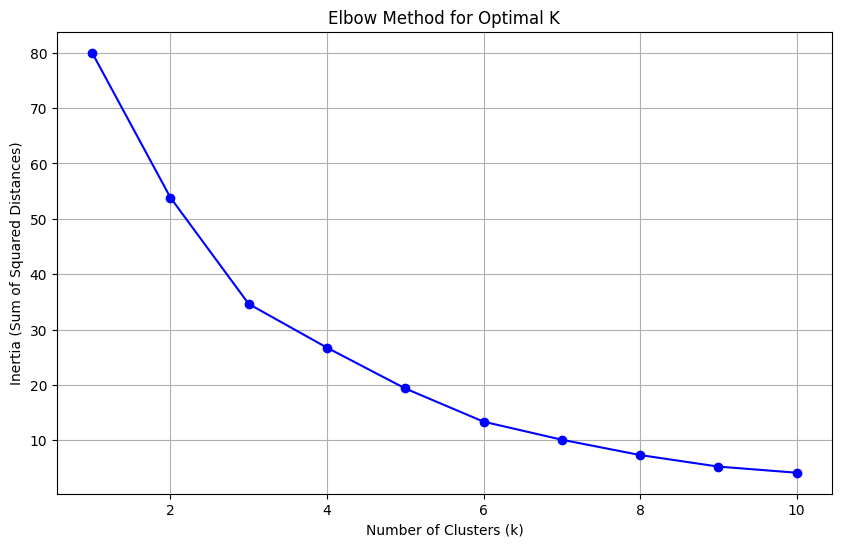

In [187]:
#Do the k-elbow plot
inertia = []
K_range = range(1, 11) 
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=20) 
    kmeans.fit(countries_scaled_filtered_df)
    inertia.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-') 
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

## Clustering Variation

PCA Loadings (Influence of each variable on the axes):
                          PC1       PC2
Economic Complexity  0.334925  0.266593
Agriculture          0.067882  0.739716
Industry            -0.470271 -0.371587
Services             0.466372 -0.473144
Manufacturing        0.555099 -0.122532
cluster_3            0.369356 -0.069227


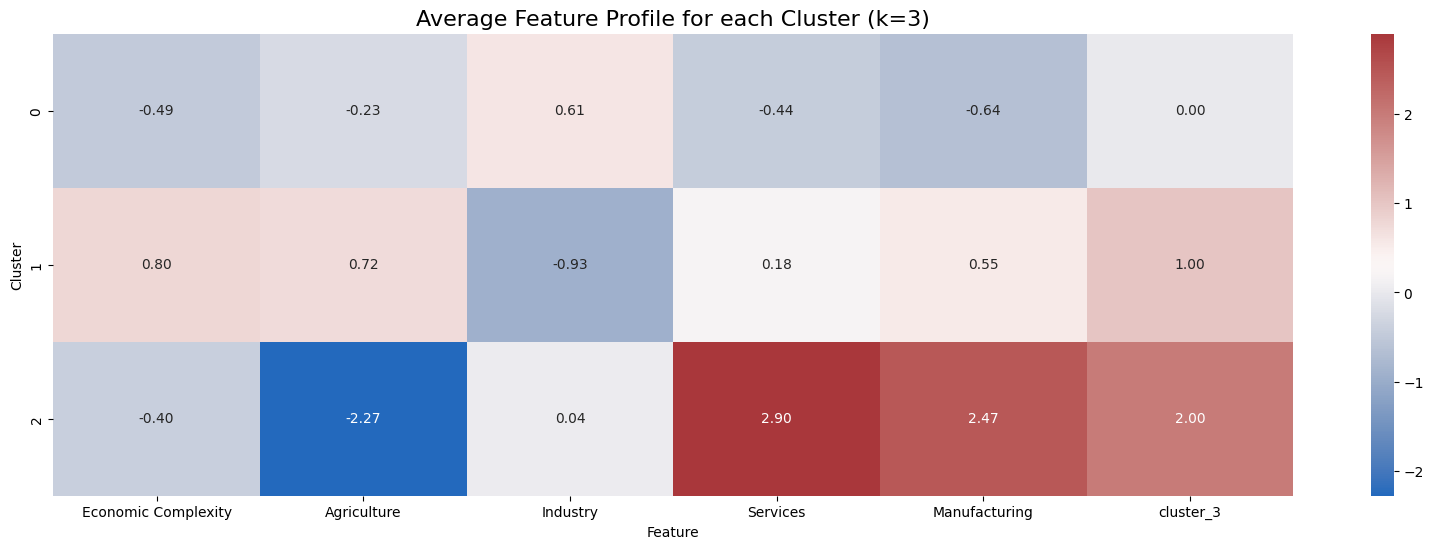

In [189]:
#Fit the k=6 model
k_country_3_filtered_var = KMeans(n_clusters=3, random_state=0, n_init=100)
k_country_3_filtered_var.fit(countries_scaled_filtered_df) 

#PCA and Visualization (as before)
data_for_pca_var = countries_scaled_filtered_df
countries_scaled_filtered_df['cluster_3'] = k_country_3_filtered_var.labels_
pca = PCA(n_components=2)
pca_components_var = pca.fit_transform(data_for_pca_var)
pca_df_var = pd.DataFrame(
    data=pca_components_var, 
    columns=['PC1', 'PC2'], 
    index=data_for_pca_var.index
)

# Add the labels from your main df
pca_df_var['cluster_3'] = countries_scaled_filtered_df['cluster_3']

# Extract Loadings 
loadings_var = pd.DataFrame(
    pca.components_.T,  
    columns=['PC1', 'PC2'],
    index=data_for_pca_var.columns  
)
print("PCA Loadings (Influence of each variable on the axes):")
print(loadings_var)

centroids_k3_var = k_country_3_filtered_var.cluster_centers_
centroid_df_k3_var = pd.DataFrame(
    centroids_k3_var, 
    columns=data_for_pca_var.columns 
)
pca_df_var['Country Code'] = pca_df_var.index 

plt.figure(figsize=(20, 6)) 
sns.heatmap(
    centroid_df_k3_var, 
    annot=True, 
    cmap='vlag', 
    fmt='.2f'
)
plt.title('Average Feature Profile for each Cluster (k=3)', fontsize=16)
plt.ylabel('Cluster')
plt.xlabel('Feature')
plt.show()

In [195]:
#Prepare DataFrame for Categorical Plotting
map_df_var = pca_df_var.copy()
map_df_var['cluster_3'] = map_df_var['cluster_3'].astype(str)

#Create the k=6 Choropleth Map 
fig_map_3_var = px.choropleth(
    map_df_var,
    locations="Country Code",
    color="cluster_3",
    hover_name=pca_df_var.index,
    hover_data=["Country Code", "cluster_3"],
    title="Clustering by change in economic outcomes and natural resource use (k=3, 2014-2021)", 
    color_discrete_sequence=px.colors.qualitative.Plotly
)
fig_map_3_var.update_geos(
    projection_type="natural earth",
    showcountries=True,
    showcoastlines=True
)

fig_map_3_var.show()

# Cluster Stability

In [ ]:
FEATURE_SET = [
    'Economic Complexity', 
    'GDP per capita PPP',
    'Government Revenue (% of GDP)',
    'Mineral rents (% of GDP)',
    'Natural gas rents (% of GDP)', 
    'Oil rents (% of GDP)',
    'Total natural resources rents (% of GDP)',
    'Natural resource rents per capita',
    'Mineral rents per capita',
    'Oil rents per capita',
    'Natural Gas rents per capita'
]


# We check intersection to ensure all columns exist before subsetting
available_cols = [c for c in FEATURE_SET if c in data_wide_imputed.columns]
datset_wide_cluster_stab = data_wide_imputed[available_cols].copy()

# Ensure no remaining NaNs (in case a column was fully empty and mean imputation failed)
data_ready_for_scaling_stab = datset_wide_cluster_stab.dropna()

scaler_filtered = StandardScaler()
countries_scaled_filtered_df_stab = pd.DataFrame(
scaler_filtered.fit_transform(datset_wide_cluster_stab),
columns=FEATURE_SET,
index=datset_wide_cluster_stab.index
)

In [ ]:
from itertools import combinations
from collections import defaultdict


K_VALUE = 6 
country_codes = data_for_clustering.index
num_countries = len(country_codes)
total_runs = 0

# Initialize a matrix to count co-occurrences for every country pair
co_occurrence_matrix = pd.DataFrame(
    0, 
    index=country_codes, 
    columns=country_codes, 
    dtype=int
)

#Iterate over all combinations of 6 features
for features_subset in combinations(FEATURE_SET, 6):
    total_runs += 1
    subset_df_stab = countries_scaled_filtered_df_stab[list(features_subset)]
    
    #Run K-Means with K=6 fixed
    kmeans_model_stab = KMeans(n_clusters=K_VALUE, random_state=total_runs, n_init=10) 
    kmeans_model_stab.fit(subset_df_stab)
    labels_stab = kmeans_model_stab.labels_
    
    #Map labels to a Series for easy lookup by country code
    assignment_series_stab = pd.Series(labels_stab, index=subset_df_stab.index)
    
    #Iterate through all unique pairs of countries
    for i in range(num_countries):
        for j in range(i, num_countries): 
            country_A = country_codes[i]
            country_B = country_codes[j]
            
            #Check if they have the same cluster assignment in this run
            if assignment_series_stab.loc[country_A] == assignment_series_stab.loc[country_B]:
                #Increment co-occurrence count
                co_occurrence_matrix.loc[country_A, country_B] += 1
                if country_A != country_B:
                    co_occurrence_matrix.loc[country_B, country_A] += 1 

print(f"\nTotal Clustering Runs Completed: {total_runs}")
print("Co-occurrence matrix populated.")
#Normalize the matrix to get the probability of co-occurrence (The Partner Stability Score)
partner_stability_matrix = co_occurrence_matrix / total_runs
average_partner_stability = (partner_stability_matrix.sum(axis=1) - 1) / (num_countries - 1)

# Sort the results
most_stable_countries = average_partner_stability.sort_values(ascending=True).head(10)
most_unstable_countries = average_partner_stability.sort_values(ascending=False).head(10)
print("\n--- Ten Most UNSTABLE Countries (Lowest Average Partner Stability Score) ---")
print(most_stable_countries)
print("\n--- Ten Most STABLE Countries (Highest Average Partner Stability Score) ---")
print(most_unstable_countries)

NameError: name 'data_for_clustering' is not defined

In [ ]:
"""#Identify Extremes (Top/Bottom 10)


#Create DataFrame for plotting (plot_df)
plot_df = average_partner_stability.to_frame(name='Partner Stability Score').reset_index()
#Reverse the dictionary to get Name -> Code mapping
name_to_code_map = {value: key for key, value in clean_map_dict.items()}
plot_df['Country Code'] = plot_df['Country Name'].map(name_to_code_map)
plot_df.columns = ['Country Code', 'Partner Stability Score']
plot_df['Stability Category'] = 'Other'


#Generate the map
color_map = {
    'Most Unstable (Top 10 Lowest)': 'red',    
    'Least Unstable (Top 10 Highest)': 'blue',  
    'Other': 'lightgrey'
}

fig_extremes = px.choropleth(
    plot_df,
    locations="Country Name",
    color="Stability Category",
    hover_name="Country Name",
    hover_data={'Partner Stability Score': ':.4f', 'Country Name': False, 'Stability Category': False},
    title="Cluster Stability by country",
    color_discrete_map=color_map,
    category_orders={"Stability Category": [
        'Top 10 most unstable countries',
        'Bottom 10 least unstable countries',
        'Other'
    ]}
)

fig_extremes.update_geos(
    projection_type="natural earth",
    showcountries=True,
    showcoastlines=True
)
fig_extremes.show()"""

'#Identify Extremes (Top/Bottom 10)\n\n\n#Create DataFrame for plotting (plot_df)\nplot_df = average_partner_stability.to_frame(name=\'Partner Stability Score\').reset_index()\n#Reverse the dictionary to get Name -> Code mapping\nname_to_code_map = {value: key for key, value in clean_map_dict.items()}\nplot_df[\'Country Code\'] = plot_df[\'Country Name\'].map(name_to_code_map)\nplot_df.columns = [\'Country Code\', \'Partner Stability Score\']\nplot_df[\'Stability Category\'] = \'Other\'\n\n\n#Generate the map\ncolor_map = {\n    \'Most Unstable (Top 10 Lowest)\': \'red\',    \n    \'Least Unstable (Top 10 Highest)\': \'blue\',  \n    \'Other\': \'lightgrey\'\n}\n\nfig_extremes = px.choropleth(\n    plot_df,\n    locations="Country Name",\n    color="Stability Category",\n    hover_name="Country Name",\n    hover_data={\'Partner Stability Score\': \':.4f\', \'Country Name\': False, \'Stability Category\': False},\n    title="Cluster Stability by country",\n    color_discrete_map=color_m

In [ ]:
most_unstable_codes = list(average_partner_stability.sort_values(ascending=True).head(10).index)
least_unstable_codes = list(average_partner_stability.sort_values(ascending=False).head(10).index)

# Add the Stability Category column 
plot_df_stab = average_partner_stability.to_frame(name='Partner Stability Score').reset_index()
plot_df_stab['Stability Category'] = 'Other'
plot_df_stab.loc[plot_df_stab['Country Name'].isin(most_unstable_codes), 'Stability Category'] = 'Most Unstable (Top 10 Lowest)'
plot_df_stab.loc[plot_df_stab['Country Name'].isin(least_unstable_codes), 'Stability Category'] = 'Least Unstable (Top 10 Highest)'

name_to_code_map = {value: key for key, value in clean_map_dict.items()}
plot_df_stab['Country Code'] = plot_df_stab['Country Name'].map(name_to_code_map)


fig_extremes = px.choropleth(
    plot_df_stab,
    locations="Country Code",  # Use Country Code instead of Country Name
    color="Stability Category",
    hover_name="Country Name",
)

fig_extremes.show()

# All visuals

## Clustering (2014-2021)

## Variation in Clustering (2014-2021)

In [ ]:
centroid_df_k6_var

,Economic Complexity,GDP per capita PPP,Government Revenue (% of GDP),Mineral rents (% of GDP),Natural gas rents (% of GDP),Oil rents (% of GDP),Total natural resources rents (% of GDP),Mineral change per capita,Oil rents change per capita,Natural resource rents change per capita,Natural Gas rents change per capita,cluster_6
0,0.007640,-0.434257,-0.097622,-0.172417,-0.280963,-0.154327,-0.298200,-0.100738,-0.097829,-0.100828,-0.101475,1.0
1,-0.007611,1.092081,0.604975,-0.074777,2.186514,0.603719,0.924662,10.516249,11.440855,11.470528,11.487636,2.0
2,-0.669569,-0.231485,0.314737,3.100761,-0.115277,-0.032185,1.881116,0.287600,-0.092562,-0.025866,-0.090488,4.0
3,-0.021650,1.304689,0.052940,-0.370090,-0.208870,-0.190442,-0.355471,-0.107443,-0.040853,-0.063987,-0.062503,5.0
4,-0.031895,-0.923650,8.644960,-0.383943,1.711005,9.211440,6.428589,-0.135770,-0.757488,-0.404967,-0.149861,3.0
5,0.681328,-0.469560,-0.641299,-0.163007,2.984757,1.024829,1.282682,-0.141131,-0.057891,-0.057473,-0.022480,0.0


In [ ]:

"""Initial map"""
# Create the k=6 Choropleth Map using df_map_var
fig_map_6 = px.choropleth(
    map_df_var,
    locations="Country Code",
    color="cluster_6",
    hover_name="Country Name",
    hover_data=["Country Code", "cluster_6"],
    color_discrete_sequence=px.colors.qualitative.Bold,
)
## Visual Enhancements 
fig_map_6.update_geos(
    projection_type="winkel tripel",
    projection_scale=1,
    showcountries=True,
    countrycolor="Gray", 
    showcoastlines=True,
    coastlinecolor="Black",
    lakecolor="LightBlue",
    oceancolor="LightBlue",
    showocean=True,
)
## Layout Enhancement 
fig_map_6.update_layout(
    width=1200, 
    height=800,
    title={
        'text': "Change in Economic Performance and Resource Use (2015-2021)",
        'y': 0.95, 
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20, 'color': 'DarkSlateGray', 'family': 'Arial'}
    },
    plot_bgcolor='rgba(0,0,0,0)', 
    paper_bgcolor='LightGray',
    legend_title_text='Cluster Group',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=0.01,
        xanchor="center",
        x=0.5
    ),
    margin={"r":0,"t":50,"l":0,"b":0}
)
fig_map_6.show()

"""Heatmap"""
plt.figure(figsize=(18, 8)) 
sns.heatmap(  
    centroid_df_k6_var.drop(columns="cluster_6"), 
    annot=True, 
    cmap='vlag',            
    fmt='.2f',               
    linewidths=0.5,          
    vmax=5.0,
    linecolor='white',
    cbar_kws={'label': 'Feature Z-Score (Std. Dev. from Mean)'}
)
plt.title(
    'Cluster Profile Analysis: which variables determine every cluster', 
    fontsize=20, 
    pad=20,
    fontweight='bold'
)
plt.ylabel('Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Feature', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12) 
plt.yticks(rotation=0, fontsize=12) 
plt.tight_layout() 
plt.show()

"""Feature selection (PCA Biplot)
# Note: Raw loadings calculation remains the same, as it's independent of the DataFrames
SCALE_FACTOR = 5 
raw_loadings = {
    'Economic Complexity': (0.5001 / SCALE_FACTOR, 3.3182 / SCALE_FACTOR),
    'GDP per capita PPP': (1.7008 / SCALE_FACTOR, 2.4624 / SCALE_FACTOR),
    'Mineral rents (% of GDP)': (-0.6492 / SCALE_FACTOR, -1.5342 / SCALE_FACTOR),
    'Natural gas rents (% of GDP)': (1.7451 / SCALE_FACTOR, -1.3901 / SCALE_FACTOR),
    'Oil rents (% of GDP)': (1.8450 / SCALE_FACTOR, -1.2846 / SCALE_FACTOR),
    'Government Revenue (% of GDP)': (1.0739 / SCALE_FACTOR, 2.4665 / SCALE_FACTOR),
    'Oil rents per capita': (2.5923 / SCALE_FACTOR, -0.6163 / SCALE_FACTOR),
    'Natural resource rents per capita': (2.6838 / SCALE_FACTOR, -0.6682 / SCALE_FACTOR),
    'Natural Gas rents per capita': (2.2716 / SCALE_FACTOR, -0.5748 / SCALE_FACTOR)
}
gov_gdp_pc1 = np.mean([raw_loadings['Government Revenue (% of GDP)'][0], raw_loadings['GDP per capita PPP'][0]])
gov_gdp_pc2 = np.mean([raw_loadings['Government Revenue (% of GDP)'][1], raw_loadings['GDP per capita PPP'][1]])
rents_gdp_pc1 = np.mean([raw_loadings['Natural gas rents (% of GDP)'][0], raw_loadings['Oil rents (% of GDP)'][0]])
rents_gdp_pc2 = np.mean([raw_loadings['Natural gas rents (% of GDP)'][1], raw_loadings['Oil rents (% of GDP)'][1]])
per_capita_pc1 = np.mean([
    raw_loadings['Oil rents per capita'][0], 
    raw_loadings['Natural resource rents per capita'][0], 
    raw_loadings['Natural Gas rents per capita'][0]
])
per_capita_pc2 = np.mean([
    raw_loadings['Oil rents per capita'][1], 
    raw_loadings['Natural resource rents per capita'][1], 
    raw_loadings['Natural Gas rents per capita'][1]
])
loadings_simplified = {
    'Economic Complexity': raw_loadings['Economic Complexity'], 
    'Mineral Rents (% GDP)': raw_loadings['Mineral rents (% of GDP)'], 
    
    'Revenue & GDP per Capita': (gov_gdp_pc1, gov_gdp_pc2),
    'Avg. Oil & Gas Rents (% GDP)': (rents_gdp_pc1, rents_gdp_pc2), 
    'Avg. Resource Rents per Capita': (per_capita_pc1, per_capita_pc2)
}
data = []
annotations = []
arrow_color = 'Black'
X_TEXT_OFFSET=0.5
for feature, (pc1_load, pc2_load) in loadings_simplified.items():
    
    # 1. Create the arrow as a shape (line)
    arrow_line = go.layout.Shape(
        type="line",
        x0=0, y0=0,
        x1=pc1_load * SCALE_FACTOR, 
        y1=pc2_load * SCALE_FACTOR,
        line=dict(color=arrow_color, width=2.5)
    )
    data.append(arrow_line)
    
    # 2. Add text annotation for the feature name
    annotations.append(go.layout.Annotation(
        x=pc1_load * SCALE_FACTOR * 1.1 + X_TEXT_OFFSET,
        y=pc2_load * SCALE_FACTOR * 1.1,
        text=feature,
        showarrow=False,
        font=dict(color=arrow_color, size=11, family='Arial Black')
    ))
fig_biplot = px.scatter(
    pca_df_var, # Renamed from pca_df
    x='PC1', 
    y='PC2', 
    color='cluster_6',
    hover_name='Country Code', 
    hover_data={
        'Country Name': True,
        'cluster_6': True, 
        'PC1': ':.2f',
        'PC2': ':.2f'
        },
    title='Simplified Interactive PCA Biplot of K-Means Clusters (k=6)',
    color_discrete_sequence=px.colors.qualitative.Bold,
    )
fig_biplot.update_layout(
    shapes=data,          
    annotations=annotations,
    title={
        'text': 'PCA Biplot of K-Means Clusters (k=6)',
        'y': 0.95, 
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20, 'color': 'DarkSlateGray', 'family': 'Arial'}
    },
    plot_bgcolor='rgba(0,0,0,0)', 
    paper_bgcolor='WhiteSmoke', 
    legend_title_text='Cluster Group',
    height=700, 
    width=1300,  
    margin={"r":20,"t":50,"l":20,"b":20}
)
fig_biplot.show()
Polygon (Radar Chart)
df_radar_data = centroids_k6_var.reset_index(names='Cluster').melt(
    id_vars='Cluster', 
    var_name='Feature', 
    value_name='Z_Score'
)
df_radar_data['Cluster'] = df_radar_data['Cluster'].astype(str)
fig_radar = px.line_polar(
    df_radar_data, # Renamed from centroid_df_long
    r='Z_Score', 
    theta='Feature', 
    color='Cluster',
    line_close=True,
    color_discrete_sequence=px.colors.qualitative.Bold, 
    title="Cluster Centroid Profiles (Z-Scores)"
)
fig_radar.update_traces(fill='toself')
fig_radar.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[-3, 3] 
        )),
    showlegend=True,
    height=600,
    width=900
)
fig_radar.show()
"""

NameError: name 'map_df_var' is not defined

# Extra

In [ ]:
coords_file_path = '/Users/leoss/Downloads/8827699-61b2107766d6fd51e2bd02d9f78f6be081340efc/countries_codes_and_coordinates.csv' 
coords_df_raw = pd.read_csv(coords_file_path)
coords_df = coords_df_raw[['Alpha-3 code', 'Latitude (average)', 'Longitude (average)']] 
coords_df.columns = ['Country Code', 'latitude', 'longitude']
coords_df['Country Code'] = coords_df['Country Code'].str.strip().str.replace('"', '', regex=False)
coords_df['latitude'] = coords_df['latitude'].str.replace('"', '', regex=False).apply(pd.to_numeric, errors='coerce')
coords_df['longitude'] = coords_df['longitude'].str.replace('"', '', regex=False).apply(pd.to_numeric, errors='coerce')
map_df_with_coords = pd.merge(
    map_df,
    coords_df[['Country Code', 'latitude', 'longitude']],
    on='Country Code', 
    how='left'
)


/var/folders/lk/thldsylx4nx779cggs7gnk900000gn/T/ipykernel_36046/2542789908.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/lk/thldsylx4nx779cggs7gnk900000gn/T/ipykernel_36046/2542789908.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/lk/thldsylx4nx779cggs7gnk900000gn/T/ipykernel_36046/2542789908.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

''

In [ ]:
fig_map_sc = px.scatter_geo(
    # Use the cleaned and merged data with successful coordinate matches
    map_df_with_coords.dropna(subset=['latitude', 'longitude']),
    lat="latitude", 
    lon="longitude", 
    color="cluster_6",
    hover_name="Country Name", 
    hover_data=["Country Code", "cluster_6"],
    color_discrete_sequence=px.colors.qualitative.Bold, 
    # Use the Winkel Tripel projection (like your initial choropleth map)
    projection="winkel tripel", 
    height=600
)

fig_map_sc.update_geos(
    showland=True,
    landcolor="LightGray",
    showocean=True,
    oceancolor="LightBlue",
    showcountries=True,
    countrycolor="DarkGray"
)

fig_map_sc.update_layout(
    title='Cluster Membership on Global Map Projection (k=6)',
    margin={"r":0,"t":50,"l":0,"b":0},
    title_x=0.5
)

fig_map_sc.show()